In [1]:
!/opt/conda/default/bin/pip install matplotlib

     |████████████████████████████████| 11.5 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 7.0 MB/s  eta 0:00:01


In [2]:
import numpy as np
import hail as hl
from hail import methods
from hail.expr import matrix_table_source
import scipy as sp
import pandas as pd
from math import sqrt, pi, ceil
from random import randint, choice
import matplotlib.pyplot as plt
import pandas as pd
import time

## Grouping and NDArray methods from Tim and Dan

In [3]:
# Functions for operating with Tables of ndarrays in Hail (from Tim)

from hail.expr import Expression, ExpressionException, \
    expr_float64, expr_call, expr_any, expr_numeric, expr_array, \
    expr_locus, \
    analyze, check_entry_indexed, check_row_indexed, \
    matrix_table_source, table_source

# Only groups by rows, NOT COLUMNS
def matrix_table_to_table_of_ndarrays(field, group_size, tmp_path = '/tmp/nd_table.ht'):
    """

    The returned table has two fields: 'row_group_number' and 'ndarray'.

    Examples
    --------
    >>> ht = matrix_table_to_table_of_ndarrays(mt.GT.n_alt_alleles(), 100)

    Parameters
    ----------
    field
    group_size
    tmp_path

    Returns
    -------

    """
    mt = matrix_table_source('matrix_table_to_table_of_ndarrays/x', field)
    mt = mt.select_entries(x = field)
    ht = mt.localize_entries(entries_array_field_name='entries')
    # now ht.entries is an array of structs with one field, x

    # we'll also want to mean-impute/variance-normalize/etc here
    ht = ht.select(xs = ht.entries.map(lambda e: e['x']))
    # now ht.xs is an array of float64

    # now need to produce groups of G
    ht = ht.add_index()
    ht = ht.group_by(row_group_number= hl.int32(ht.idx // group_size)) \
        .aggregate(ndarray=hl.nd.array(hl.agg.collect(ht.xs)))
    # may require a .T on ndarray

    return ht.checkpoint(tmp_path, overwrite=True)

def chunk_ndarray(a, group_size):
    """Chunks a NDarray along the first axis in chunks of `group_size`.
    Parameters
    ----------
    a
    group_size
    -------

    """
    n_groups = ceil(a.shape[0] / group_size)
    groups = []
    for i in range(n_groups):
        start = i * group_size
        if i == n_groups - 1:
            end = a.shape[0]
        else:
            end = (i + 1) * group_size
        groups.append(a[start:end, :])
    return groups


# Concatenate the ndarrays with a blocked Table
def concatBlocked(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    ht = ndarray_to_table([big_mat])
    return ht

def concatToNumpy(A):
    blocks = A.ndarray.collect()
    big_mat = np.concatenate(blocks, axis=0)
    return big_mat

def ndarray_to_table(chunked_arr):
    structs = [hl.struct(row_group_number = idx, ndarray = block)
               for idx, block in enumerate(chunked_arr)]
    ht = hl.Table.parallelize(structs)
    ht = ht.key_by('row_group_number')
    return ht

# function to multiply two blocks, given the two blocks
# returns struct in form of array but not ndarray, includes the shape in the struct
# to change the result product directly back into a ndarray we need to use from_column_major
def block_product(left, right):
    product = left @ right     
    n_rows, n_cols = product.shape
    return hl.struct(
        shape=product.shape,
        block=hl.range(hl.int(n_rows * n_cols)).map(
            lambda absolute: product[absolute % n_rows, absolute // n_rows]))

# takes in output of block_product
def block_aggregate(prod):
    shape = prod.shape
    block = prod.block
    return hl.nd.from_column_major(
        hl.agg.array_sum(block),
        hl.agg.take(shape, 1)[0])

# returns flat array
def to_column_major(ndarray):
    n_rows, n_cols = ndarray.shape
    return hl.range(hl.int(n_rows * n_cols)).map(
        lambda absolute: ndarray[absolute % n_rows, absolute // n_rows])

# hl.nd.from_column_major(thing.the_sum, thing.the_shape)

## Blanczos Algorithm

In [45]:
# Algorithm step: multiplying H0 = A @ G

# METHOD
# Multiply a row-blocked matrix by a local non-blocked matrix
# First step of algorithm

# Usage:
# assumes blocks in blocked matrix are named ndarray
# A is a table, B is a Hail ndarray
# returns a table

# Example:
# H0 = matmul_rowblocked_nonblocked(data, G)

def matmul_rowblocked_nonblocked(A, B):
    temp = A.annotate_globals(mat = B)
    temp = temp.annotate(ndarray = temp.ndarray @ temp.mat)
    temp = temp.select(temp.ndarray)
    temp = temp.drop(temp.mat)
    return temp


# Algorithm step: intermediate operation of multiplying At @ (A @ G) = At @ H0

# METHOD
# Multiply a column-blocked matrix by a row-blocked matrix 
# as a blockmatrix multiplcation and then sum
# Second step of algorithm

# Usage:
# pass in matrix A normally, blocked in rows - this specifically expects A to need to be transposed
# assumes blocks in blocked matrix are named ndarray
# A and B are both tables
# returns a hail ndarray

# Example:
# G1 = matmul_colblocked_rowblocked(data, H0)

def matmul_colblocked_rowblocked(A, B):
    temp = A.transmute(ndarray = block_product(A.ndarray.transpose(), B[A.row_group_number].ndarray))
    result_arr_sum = temp.aggregate(block_aggregate(temp.ndarray))
    return result_arr_sum

# def matmul_colblocked_rowblocked(A, B):
#     temp = A.transmute(ndarray = A.ndarray.transpose() @ B[A.row_group_number].ndarray)
#     return temp.aggregate(hl.agg.ndarray_sum(temp.ndarray))

# Algorithm step: perform QR decomposition of Hq and compute T = Q^T @ A
# Perform QR decomposition of a row-blocked matrix
# Third and fourth step of algorithm

# def computeNextH(A, H):
#     nextG = matmul_colblocked_rowblocked(A, H)
#     return matmul_rowblocked_nonblocked(A, nextG)

# def q_iteration(A, G):
#     temp = A.annotate(H_i = A.ndarray @ G.ndarray)
#     temp = temp.annotate(G_i_intermediate = temp.ndarray.T @ temp.H_i)
#     result = temp.aggregate(hl.struct(Hi_chunks = hl.agg.collect(temp.H_i), G_i = hl.agg.ndarray_sum(temp.G_i)))
#     localized_H_i = np.concat(result.Hi_chunks, axis = 1)
#     G_i = result.G_i
#     return localized_H_i, G_i

 

In [53]:
def hailBlanczos(A, G, m, n, k, l, q, block_size):
    
    # assert l > k
    # assert (q+1)*l <= (n - k)
    # assert n <= m
    
    start = time.time()
    
    h_list = []
    G_i = G

    for j in range(0, q + 1):
        temp = A.annotate(H_i = A.ndarray @ G_i)
        temp = temp.annotate(G_i_intermediate = temp.ndarray.T @ temp.H_i)
        result = temp.aggregate(hl.struct(Hi_chunks = hl.agg.collect(temp.H_i), G_i = hl.agg.ndarray_sum(temp.G_i_intermediate)))
        localized_H_i = np.vstack(result.Hi_chunks)
#         localized_H_i = np.concatenate(result.Hi_chunks, axis = 1)
        h_list.append(localized_H_i)
        G_i = result.G_i
    
    H = np.hstack(h_list)        
                            
    # assert npH.shape == (m, (q+1)*l)
    # perform QR decomposition on unblocked version of H
    Q, R = np.linalg.qr(H)
    # assert Q.shape == (m, (q+1)*l)
    # block Q's rows into the same number of blocks that A has
    blocked_Q_table = ndarray_to_table(chunk_ndarray(Q, block_size))
    
    T = matmul_colblocked_rowblocked(blocked_Q_table, A)
    # assert T.shape == ((q+1)*l, n)
    
    U, S, W = np.linalg.svd(T, full_matrices=False)
    # assert U.shape == ((q+1)*l, n)
    # assert S.shape == (n,)
    # assert W.shape == (n, n)
    
    sing_val = S[k]
    
    V = matmul_rowblocked_nonblocked(blocked_Q_table, U)
    arr_V = concatToNumpy(V)
    
    end = time.time()
    
    truncV = arr_V[:,:k]
    truncS = S[:k]
    truncW = W[:k,:]
    
    #bound, satC = blanczosErrorB(truncV, np.diag(truncS), truncW.transpose(), m, n, k, q, concatToNumpy(A), sing_val)
    
    return truncV, truncS, truncW, sing_val, Q, end - start #, bound, satC


## NumPy implementation from other notebook

In [47]:
# ALL TRANSPOSED FROM ABOVE IMPLEMENTATION

def hwe_normalize(call_expr):
    mt = call_expr._indices.source
    mt = mt.select_entries(__gt=call_expr.n_alt_alleles())
    mt = mt.annotate_rows(__AC=hl.agg.sum(mt.__gt),
                          __n_called=hl.agg.count_where(hl.is_defined(mt.__gt)))
    mt = mt.filter_rows((mt.__AC > 0) & (mt.__AC < 2 * mt.__n_called))

    n_variants = mt.count_rows()
    if n_variants == 0:
        raise FatalError("hwe_normalized: found 0 variants after filtering out monomorphic sites.")

    mt = mt.annotate_rows(__mean_gt=mt.__AC / mt.__n_called)
    mt = mt.annotate_rows(
        __hwe_scaled_std_dev=hl.sqrt(mt.__mean_gt * (2 - mt.__mean_gt) * n_variants / 2))
    mt = mt.unfilter_entries()

    normalized_gt = hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0)
    return normalized_gt

#Blanczos paper error bound 4.23
def blanczosErrorA(U, S, V, m, n, k, q, A, k1th_sing_val):
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = 100 * l * (((m-k)/l) ** (1/(4*q + 2))) * k1th_sing_val
    print('value:', norm_diff, 'bound/upper limit:', bound)
    return norm_diff <= bound

def blanczosErrorB(U, S, V, m, n, k, q, A, k1th_sing_val):
    C = 1
    norm_diff = np.linalg.norm(A - U @ S @ V.transpose())
    bound = C * (m ** (1/(4*q))) * k1th_sing_val
    satisfyingC = norm_diff / bound
    print('difference A - USV:', norm_diff, 'bound/upper limit:', bound)
    print('C constant needed to satisfy bound:', satisfyingC)
    return norm_diff <= bound, satisfyingC

def normQQtA(A, Q):
    return np.linalg.norm(A - Q @ Q.transpose() @ A)

def numpyBlanczos(A, m, n, k, l, q, G):

    assert l > k
    # assert (q+1)*l <= (m - k)
    assert m <= n

    # G = np.random.normal(0, 1, (l, m))
    R = G @ A
    # AtA = A.transpose() @ A
    listR = [R]
    for i in range(0, q):
        Ri = (listR[i] @ A.transpose()) @ A
        listR.append(Ri)
        R = np.concatenate((R, Ri), axis=0)

    assert R.shape == ((q+1)*l, n)
    (Q, S) = np.linalg.qr(R.transpose())
    assert Q.shape == (n, (q+1)*l)
    assert S.shape == ((q+1)*l, (q+1)*l)

    T = A @ Q
    assert T.shape == (m, (q+1)*l)
    
    (Tu, Ts, Tw) = np.linalg.svd(T, full_matrices=False)
    assert Tu.shape, (m, (q+1)*l)
    print(Ts.shape, (q+1)*l)
    assert Ts.shape == ((q+1)*l,)
    assert Tw.shape == ((q+1)*l, (q+1)*l)
    
    sing_val = Ts[k]
    
    V = Q @ Tw
    
    bound = blanczosErrorB(Tu, np.diag(Ts), V, m, n, k, q, A, sing_val)
    
    return Tu[:,:k], Ts[:k], V[:k,:], sing_val, Q


## Run NumPy and Hail implementations on the same data

In [9]:
def makeSharedData(model_input, block_size):
    
    # we should have m > n for hail implementation
    mt = hl.balding_nichols_model(*model_input)
    
    mt.write("balding_nichols_data.mt", overwrite=True)
    mt = hl.read_matrix_table("balding_nichols_data.mt")
    
    mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles())) 
    table = matrix_table_to_table_of_ndarrays(mt.n_alt, block_size, tmp_path='/tmp/test_table.ht')
    
    # for numpy implementation we want transposed version so m < n
    np_matrix = np.asmatrix(concatToNumpy(table))

    return table, np_matrix, mt # THIS WAS PREVIOUSLY JUST RETURNING table, np_matrix

m = 1117
n = 97
block_size = 4
hailA, numpyA, _ = makeSharedData((3, n, m), block_size)

# doesn't account for differences due to transposing
# hailV not necessarily supposed to be the same as blanczosU

2020-08-10 20:24:56 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 97 samples, and 1117 variants...
2020-08-10 20:24:56 Hail: INFO: Coerced sorted dataset
2020-08-10 20:25:01 Hail: INFO: wrote matrix table with 1117 rows and 97 columns in 8 partitions to balding_nichols_data.mt
2020-08-10 20:25:02 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-10 20:25:05 Hail: INFO: wrote table with 280 rows in 8 partitions to /tmp/test_table.ht


In [42]:
k = 10
l = k + 2
q = 3
G = np.random.normal(0, 1, (n,l))

In [11]:
def timeNumpyLibrary(data):
    start = time.time()
    _, S, _ = np.linalg.svd(data, full_matrices=False)
    end = time.time()
    return end - start

def convertSVDtoPCA(data, U, S, V):
    # might need to center data first??
    m = data.shape[0]
    scores = sqrt(m - 1) * U
    loadings = V @ S / sqrt(m - 1)
    eigens = S @ S / sqrt(m - 1)
    return eigens, scores, loadings

In [51]:
hailV, hailS, hailW, hailSingVal, hailQ, _ = hailBlanczos(hailA, hl.nd.array(G), m, n, k, l, q, block_size)

2020-08-10 20:56:06 Hail: INFO: Coerced sorted dataset
2020-08-10 20:56:07 Hail: INFO: Coerced sorted dataset


In [52]:
_, npS, _ = np.linalg.svd(numpyA.T, full_matrices=False)

hailS - npS[:k]

array([-5.68434189e-14, -1.31728513e-08, -6.78097862e-08, -1.46313378e-02,
       -1.21801708e-01, -3.04540941e-01, -7.88425115e-02, -7.03098463e-02,
       -1.31174045e-01, -1.19542791e-01])

In [12]:
#numpyU, numpyS, numpyV, numpySingVal, numpyQ = numpyBlanczos(numpyA.transpose(), n, m, k, l, q, G.transpose())

In [13]:
# print('largest singular value from hail:', hailS[0])
# print('smallest singular value from hail:', hailS[k-1])
# print(hailS.shape)
# print(numpyS.shape)
# hailS - numpyS

In [14]:
# normQQtA(numpyA.transpose(), hailQ)

In [15]:
# print(numpyA.shape)
# print(numpyQ.shape)
# normQQtA(numpyA, numpyQ.transpose())

In [25]:
def test_blanczos_against_hail():
        
#     hl.utils.get_1kg('data/')
#     hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite=True)
#     mt = hl.read_matrix_table('data/1kg.mt')
    
#     mt = hl.balding_nichols_model(3, 100, 1000)
#     mt = mt.transmute_entries(n_alt = hl.float64(mt.GT.n_alt_alleles()))

#     ht = mt.localize_entries("ent", "sample") 
#     ht = ht.transmute(n_alt = hl.nd.array(mt.n_alt))
#     rows = ht.n_alt.collect()
#     np_matrix = np.asmatrix(np.concatenate(rows, axis=0))

    _, np_matrix, mt = makeSharedData((3, 100, 1000), 4)

    blanczos_u, blanczos_s, blanczos_v = hl._blanczos_pca(hl.int(hl.is_defined(mt.n_alt)), k=3)
    blanczos_eigens, blanczos_scores, blanczos_loadings = convertSVDtoPCA(np_matrix, blanczos_u, blanczos_s, blanczos_v)
    eigens, scores, loadings = hl.pca(hl.int(hl.is_defined(mt.n_alt)), k=3)
    #diff = blanczos_vals - np_vals
    print(blanczos_vals)
    #print(hail_vals)
    return 

test_blanczos_against_hail()

2020-08-07 22:14:21 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 100 samples, and 1000 variants...
2020-08-07 22:14:21 Hail: INFO: Coerced sorted dataset
2020-08-07 22:14:29 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 8 partitions to balding_nichols_data.mt
2020-08-07 22:14:33 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:37 Hail: INFO: wrote table with 250 rows in 8 partitions to /tmp/test_table.ht
2020-08-07 22:14:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:41 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:42 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:43 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:44 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-08-07 22:14:44 Hail: INFO: Ordering u

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 100)

In [17]:
hl.utils.get_1kg('data/')
hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite=True)
mt = hl.read_matrix_table('data/1kg.mt')

def cleanMissingData(mt):

    call_expr = mt.GT
    mt = call_expr._indices.source
    mt = mt.select_entries(__gt=call_expr.n_alt_alleles())
    mt = mt.annotate_rows(__AC=hl.agg.sum(mt.__gt),
                          __n_called=hl.agg.count_where(hl.is_defined(mt.__gt)))
    mt = mt.filter_rows((mt.__AC > 0) & (mt.__AC < 2 * mt.__n_called))

    n_variants = mt.count_rows()
    if n_variants == 0:
        raise FatalError("hwe_normalized: found 0 variants after filtering out monomorphic sites.")

    mt = mt.annotate_rows(__mean_gt=mt.__AC / mt.__n_called)
    mt = mt.annotate_rows(__hwe_scaled_std_dev=hl.sqrt(mt.__mean_gt * (2 - mt.__mean_gt) * n_variants / 2))
    mt = mt.unfilter_entries()
    mt = mt.annotate_entries(__gt = hl.or_else((mt.__gt - mt.__mean_gt) / mt.__hwe_scaled_std_dev, 0.0))
    
    return mt

cleanMissingData(mt).describe()

2020-08-09 19:34:28 Hail: INFO: 1KG files found
2020-08-09 19:34:29 Hail: INFO: Coerced sorted dataset
2020-08-09 19:34:42 Hail: INFO: wrote matrix table with 10879 rows and 284 columns in 1 partition to data/1kg.mt


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    }
    '__AC': int64
    '__n_called': int64
    '__mean_gt': float32
    '__hwe_scaled_std_dev': float64
----------------------------------------
Entry fields:
    '__gt': int32
-----------------

In [18]:
big_df = pd.read_csv('gs://aotoole/blanczos_data_combinatorial.csv')
big_df['MxN'] = big_df.apply(lambda row: row.M * row.N, axis=1)
big_df

,Unnamed: 0,M,N,block size,K,L,Q,blanczos time,numpy time,MxN
0,0,100.0,50.0,2.0,10.0,12.0,1.0,2.719306,0.005315,5000.0
1,1,100.0,50.0,4.0,10.0,12.0,1.0,1.779193,0.001401,5000.0
2,2,100.0,50.0,8.0,10.0,12.0,1.0,1.675353,0.001228,5000.0
3,3,100.0,50.0,16.0,10.0,12.0,1.0,1.427350,0.001386,5000.0
4,4,100.0,50.0,32.0,10.0,12.0,1.0,1.375496,0.001397,5000.0
...,...,...,...,...,...,...,...,...,...,...
117,192,50000.0,1000.0,8.0,10.0,12.0,1.0,40.563137,2.375593,50000000.0
118,193,50000.0,1000.0,16.0,10.0,12.0,1.0,37.206307,2.434065,50000000.0
119,194,50000.0,1000.0,32.0,10.0,12.0,1.0,35.526451,2.403668,50000000.0
120,195,50000.0,5000.0,2.0,10.0,12.0,1.0,94.781509,49.736327,250000000.0


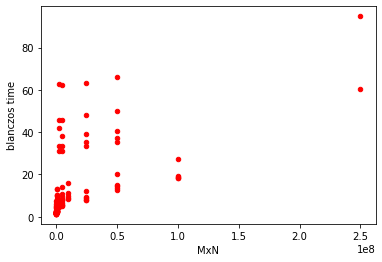

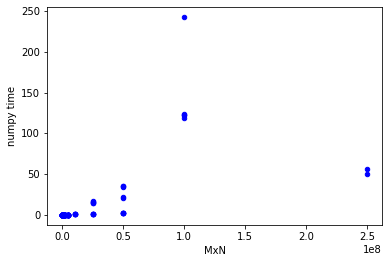

In [19]:
big_df.plot(kind='scatter',x='MxN',y='blanczos time',color='red')
big_df.plot(kind='scatter',x='MxN',y='numpy time',color='blue')
plt.show()

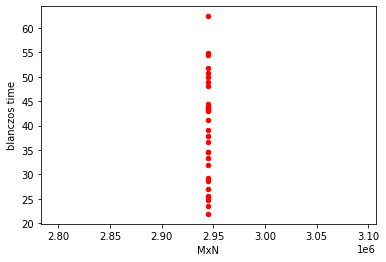

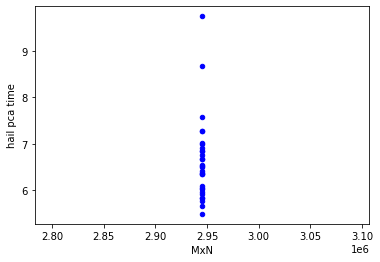

In [20]:
newdata_small = pd.read_csv('gs://aotoole/blanczos_newsmalldata_times.csv')
newdata_small['MxN'] = newdata_small.apply(lambda row: row.M * row.N, axis=1)
newdata_small.plot(kind='scatter',x='MxN',y='blanczos time',color='red')
newdata_small.plot(kind='scatter',x='MxN',y='hail pca time',color='blue')
plt.show()

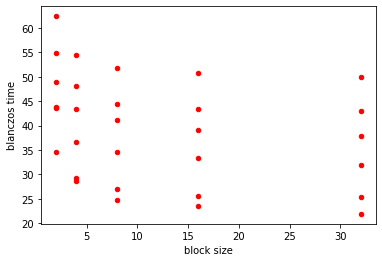

In [21]:
newdata_small.plot(kind='scatter',x='block size',y='blanczos time',color='red')
# newdata_small.plot(kind='scatter',x='MxN',y='hail pca time',color='blue')
plt.show()

In [7]:
medium_data = hl.experimental.load_dataset(name='1000_Genomes_autosomes', version='phase_3' ,reference_genome='GRCh38')
medium_data = medium_data.filter_rows(medium_data.variant_qc.AF[1] > 0.01)
medium_data.summarize()

2020-08-10 14:58:05 Hail: INFO: Coerced sorted dataset


Non-missing,2504 (100.00%)
Missing,0
Min Size,7
Max Size,7
Mean Size,7.00
Sample Values,"['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101']"
Non-missing,2504 (100.00%)
Missing,0
Min Size,3
Max Size,3
Mean Size,3.00


Non-missing,8237971 (100.00%)
Missing,0
Contig Counts,"{'chr11': 405605, 'chr5': 509234, 'chr22': 114720, 'chr8': 445585, 'chr19': 194285, 'chr1': 666411, 'chr15': 241806, 'chr12': 383964, 'chr18': 235141, 'chr20': 177089, 'chr2': 678316, 'chr13': 303954, 'chr7': 482456, 'chr14': 266926, 'chr3': 584916, 'chr17': 225905, 'chr4': 605870, 'chr6': 549352, 'chr9': 354504, 'chr10': 436214, 'chr21': 120240, 'chr16': 255478}"
Non-missing,8237971 (100.00%)
Missing,0
Min Size,2
Max Size,2
Mean Size,2.00
Non-missing,16475942 (100.00%)
Missing,0
Min Size,1


KeyboardInterrupt: 

In [8]:
medium_data.describe()

----------------------------------------
Global fields:
    'metadata': struct {
        name: str, 
        version: str, 
        reference_genome: str, 
        n_rows: int32, 
        n_cols: int32, 
        n_partitions: int32
    }
----------------------------------------
Column fields:
    's': str
    'population': str
    'super_population': str
    'is_female': bool
    'family_id': str
    'relationship_role': str
    'maternal_id': str
    'paternal_id': str
    'children_ids': array<str>
    'sibling_ids': array<str>
    'second_order_relationship_ids': array<str>
    'third_order_relationship_ids': array<str>
    'sample_qc': struct {
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_trans

In [5]:
newdata_medium = pd.read_csv('gs://aotoole/blanczos_medium_data_times.csv')
newdata_medium['MxN'] = newdata_medium.apply(lambda row: row.M * row.N, axis=1)
newdata_medium.plot(kind='scatter',x='MxN',y='blanczos time',color='red')
newdata_medium.plot(kind='scatter',x='MxN',y='hail pca time',color='blue')
plt.show()

FileNotFoundError: https://www.googleapis.com/storage/v1/b/aotoole/o/blanczos_medium_data_times.csv